In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt


In [2]:
import numpy as np
from matplotlib import pyplot as plt
from keras.models import Model


In [3]:
BATCH_SIZE = 16
IMAGE_SIZE = 256

CHANNELS=3  
EPOCHS=80


In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "apple",
    shuffle=True,
    
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
    
)

Found 1693 files belonging to 6 classes.


potato_early_blight = "/content/drive/MyDrive/potato-disease/potato-disease/training/PlantVillage/Potato_Early_blight"

potato_lately_blight = "/content/drive/MyDrive/potato-disease/potato-disease/training/PlantVillage/Potato___Late_blight"

potato_healthy = "/content/drive/MyDrive/potato-disease/potato-disease/training/PlantVillage/Potato___healthy"

In [5]:
class_names = dataset.class_names

class_names

['APPLE BLACK ROT',
 'APPLE HEALTHY LEAVES',
 'APPLE LEAF BLOTCH',
 'APPLE ROT LEAVES',
 'APPLE SCAB LEAVES',
 'Apple___Cedar_apple_rust']

In [6]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())  #batch size 32 256 image size 

(16, 256, 256, 3)
[5 1 3 5 1 1 3 4 3 2 1 1 3 4 4 2]


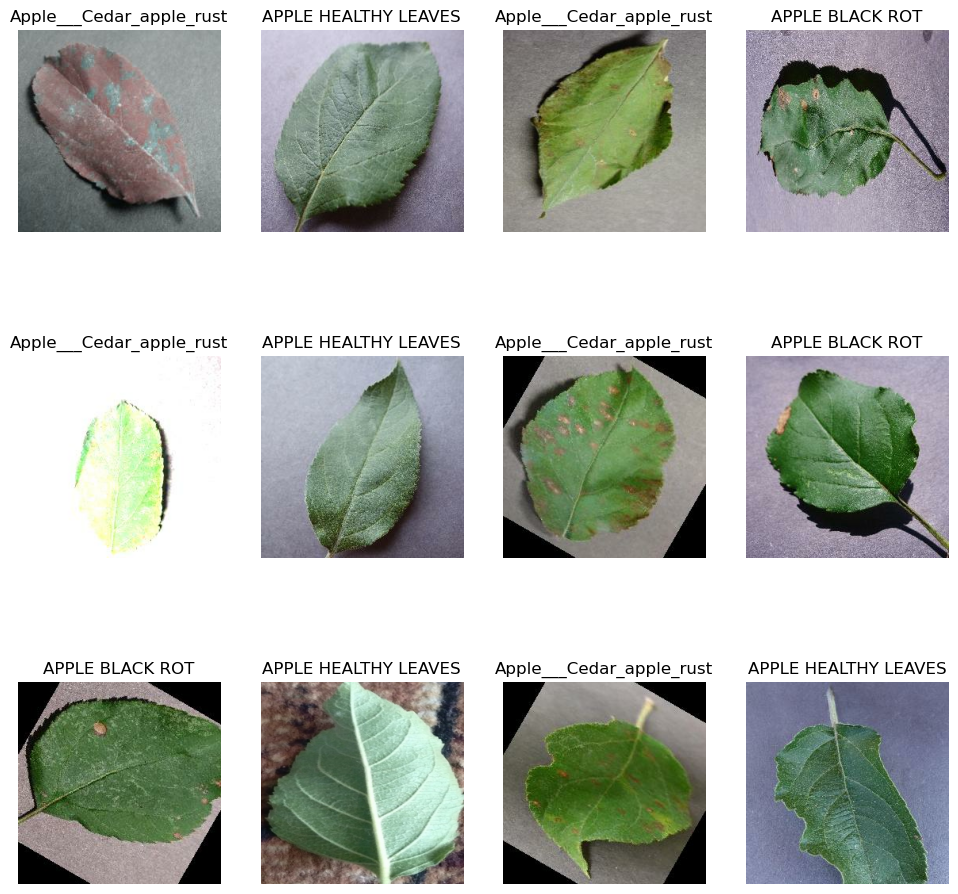

In [7]:
plt.figure(figsize=(12, 12))
for image_batch, labels_batch in dataset.take(1):  
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1) #plot
        plt.imshow(image_batch[i].numpy().astype("uint8"))  #random
        plt.title(class_names[labels_batch[i]]) 
        plt.axis("off")

# SPLITTING

80% ==>training 20% ==>10% for testing other 10% for validating

In [8]:
len(dataset)    #total images/batch size


106

In [9]:
train_size = 0.8                #580*.8  for training


In [10]:
len(dataset)*train_size


84.80000000000001

In [11]:
train_ds = dataset.take(84)     


In [12]:
len(train_ds)

84

In [13]:
test_ds = dataset.skip(84)


In [14]:
len(test_ds)

22

In [15]:
val_size=0.1


In [16]:
len(dataset)*val_size

10.600000000000001

In [17]:
val_ds = test_ds.take(10)


In [18]:
len(val_ds)

10

In [19]:
test_ds = test_ds.skip(10)


In [20]:
len(test_ds)

12

In [21]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=20000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [22]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [23]:
len(train_ds)

84

In [24]:
len(val_ds)

10

In [25]:
len(test_ds)

12

In [26]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


# Getting images into same size

In [27]:
resize_and_rescale = tf.keras.Sequential([
    
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
    
])


Changing the image style


In [28]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])


BUILDING THE MODEL


In [29]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [30]:

input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 6


In [31]:
model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])


In [32]:
model.build(input_shape=input_shape)

In [33]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (16, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (16, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (16, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (16, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (16, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (16, 60, 60, 64)         

In [34]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [35]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=80,
)

Epoch 1/80
84/84 [==============================] - 173s 2s/step - loss: 1.6896 - accuracy: 0.2364 - val_loss: 1.6135 - val_accuracy: 0.3125
Epoch 2/80
84/84 [==============================] - 147s 2s/step - loss: 1.5438 - accuracy: 0.3505 - val_loss: 1.5677 - val_accuracy: 0.3063
Epoch 3/80
84/84 [==============================] - 178s 2s/step - loss: 1.2916 - accuracy: 0.4907 - val_loss: 1.0891 - val_accuracy: 0.6000
Epoch 4/80
84/84 [==============================] - 103s 1s/step - loss: 1.0368 - accuracy: 0.6137 - val_loss: 0.9795 - val_accuracy: 0.6250
Epoch 5/80
84/84 [==============================] - 97s 1s/step - loss: 0.9813 - accuracy: 0.6279 - val_loss: 1.0380 - val_accuracy: 0.6062
Epoch 6/80
84/84 [==============================] - 100s 1s/step - loss: 0.9186 - accuracy: 0.6480 - val_loss: 0.9182 - val_accuracy: 0.6375
Epoch 7/80
84/84 [==============================] - 104s 1s/step - loss: 0.8367 - accuracy: 0.6756 - val_loss: 1.4023 - val_accuracy: 0.5562
Epoch 8/80
84/

Epoch 59/80
84/84 [==============================] - 157s 2s/step - loss: 0.1894 - accuracy: 0.9247 - val_loss: 0.6849 - val_accuracy: 0.7750
Epoch 60/80
84/84 [==============================] - 157s 2s/step - loss: 0.2142 - accuracy: 0.9105 - val_loss: 0.8523 - val_accuracy: 0.7500
Epoch 61/80
84/84 [==============================] - 157s 2s/step - loss: 0.2123 - accuracy: 0.9195 - val_loss: 0.7251 - val_accuracy: 0.7812
Epoch 62/80
84/84 [==============================] - 159s 2s/step - loss: 0.1910 - accuracy: 0.9247 - val_loss: 0.6246 - val_accuracy: 0.7688
Epoch 63/80
84/84 [==============================] - 158s 2s/step - loss: 0.2376 - accuracy: 0.9083 - val_loss: 0.7340 - val_accuracy: 0.7750
Epoch 64/80
84/84 [==============================] - 157s 2s/step - loss: 0.1701 - accuracy: 0.9336 - val_loss: 0.7493 - val_accuracy: 0.7875
Epoch 65/80
84/84 [==============================] - 158s 2s/step - loss: 0.2081 - accuracy: 0.9247 - val_loss: 0.7285 - val_accuracy: 0.7500
Epoch 

In [36]:
scores = model.evaluate(test_ds)

12/12 [==============================] - 5s 270ms/step - loss: 0.3378 - accuracy: 0.8542


In [37]:
scores

[0.3378014862537384, 0.8541666865348816]

In [38]:
history

In [39]:
history.params

{'verbose': 1, 'epochs': 80, 'steps': 84}

In [40]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [41]:
type(history.history['loss'])

list

In [42]:
len(history.history['loss'])

80

In [43]:
history.history['loss'][:5] 

[1.689645528793335,
 1.543797254562378,
 1.2915947437286377,
 1.0368340015411377,
 0.9813376069068909]

In [44]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

print(val_acc)

[0.3125, 0.3062500059604645, 0.6000000238418579, 0.625, 0.606249988079071, 0.637499988079071, 0.5562499761581421, 0.6625000238418579, 0.6000000238418579, 0.6187499761581421, 0.699999988079071, 0.6812499761581421, 0.6499999761581421, 0.6937500238418579, 0.7250000238418579, 0.7250000238418579, 0.6812499761581421, 0.7124999761581421, 0.71875, 0.71875, 0.6937500238418579, 0.737500011920929, 0.7250000238418579, 0.7124999761581421, 0.8062499761581421, 0.737500011920929, 0.71875, 0.6625000238418579, 0.7124999761581421, 0.6812499761581421, 0.71875, 0.7250000238418579, 0.706250011920929, 0.75, 0.731249988079071, 0.7124999761581421, 0.6625000238418579, 0.6812499761581421, 0.7749999761581421, 0.7437499761581421, 0.699999988079071, 0.737500011920929, 0.7250000238418579, 0.731249988079071, 0.675000011920929, 0.8062499761581421, 0.7749999761581421, 0.675000011920929, 0.75, 0.768750011920929, 0.7124999761581421, 0.699999988079071, 0.7250000238418579, 0.75, 0.699999988079071, 0.7124999761581421, 0.762

In [45]:
loss = history.history['loss']
val_loss = history.history['val_loss']

print(val_loss)

[1.6134580373764038, 1.5676958560943604, 1.0890591144561768, 0.9795364141464233, 1.0380316972732544, 0.9181830286979675, 1.402262806892395, 0.957660973072052, 0.9018921852111816, 1.0121653079986572, 0.8491088151931763, 0.8416563272476196, 0.8858762979507446, 0.8175374269485474, 0.6855778694152832, 0.8091996908187866, 1.0531731843948364, 0.7273178100585938, 0.6756561398506165, 0.6801422834396362, 0.7392808794975281, 0.7025726437568665, 0.7408568859100342, 0.6940945386886597, 0.5824105143547058, 0.7162177562713623, 0.6566959619522095, 0.9906946420669556, 0.8934691548347473, 0.9700747728347778, 0.9119402170181274, 0.6889337301254272, 0.9425946474075317, 0.787338376045227, 0.7969362139701843, 0.7772271037101746, 0.8839337229728699, 0.9142168164253235, 0.6217964887619019, 0.7820708751678467, 1.0312795639038086, 0.6087878942489624, 0.9718466997146606, 0.5667818784713745, 1.2419129610061646, 0.5574124455451965, 0.6859272718429565, 1.116527795791626, 0.8319469690322876, 0.8729701042175293, 0.8

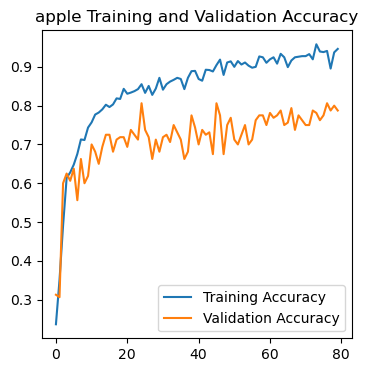

In [46]:
plt.figure(figsize=(4, 4))

plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('apple Training and Validation Accuracy')


plt.show()

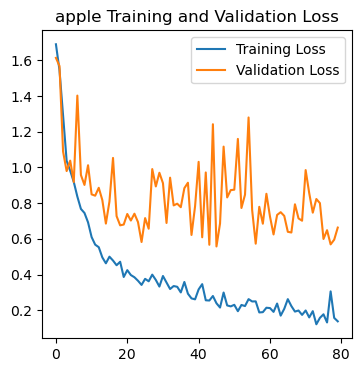

In [47]:
plt.figure(figsize=(4, 4))
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('apple Training and Validation Loss')

plt.show()

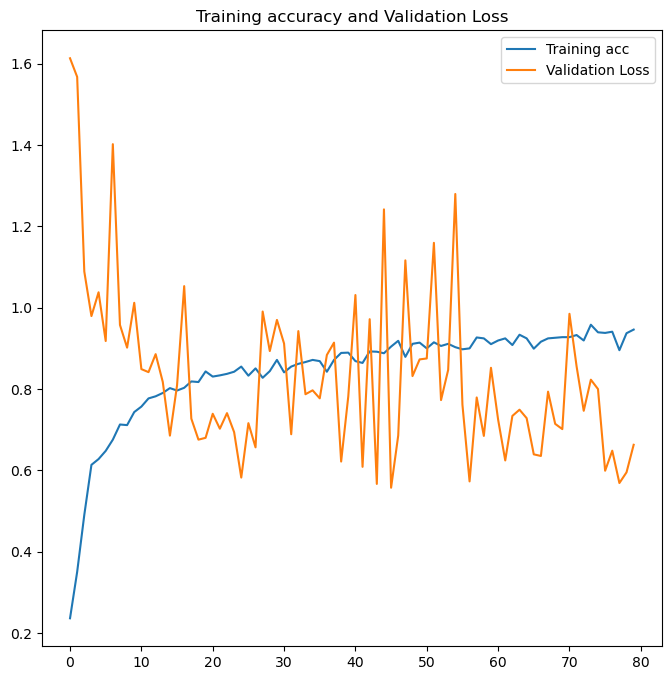

In [48]:
plt.figure(figsize=(8, 8))
plt.plot(range(EPOCHS), acc, label='Training acc')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training accuracy and Validation Loss')

plt.show()

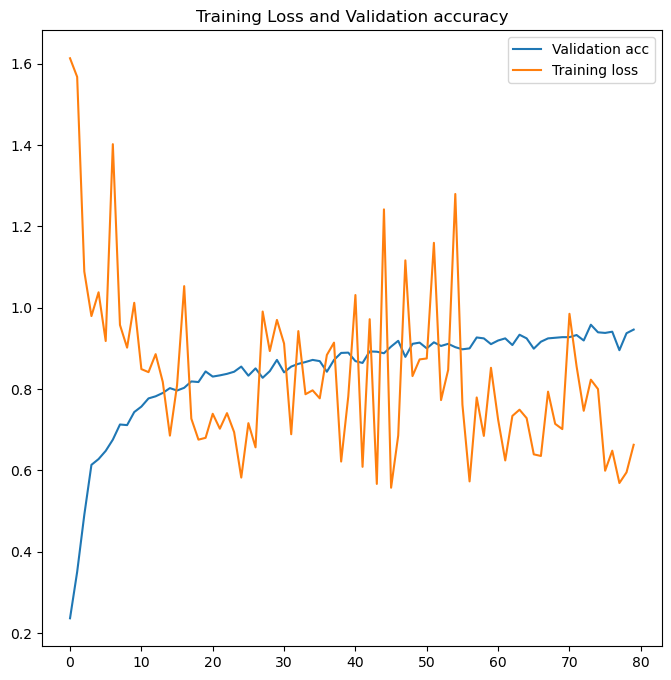

In [49]:
plt.figure(figsize=(8, 8))
plt.plot(range(EPOCHS), acc, label='Validation acc')
plt.plot(range(EPOCHS), val_loss, label='Training loss')
plt.legend(loc='upper right')
plt.title('Training Loss and Validation accuracy')

plt.show()

first image to predict
actual label: APPLE BLACK ROT
1/1 [==============================] - 0s 420ms/step
predicted label: APPLE BLACK ROT


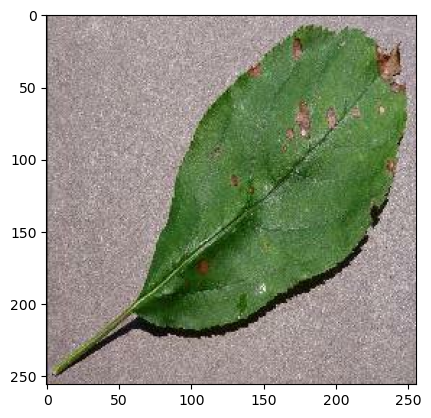

In [50]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])


In [51]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 37ms/step


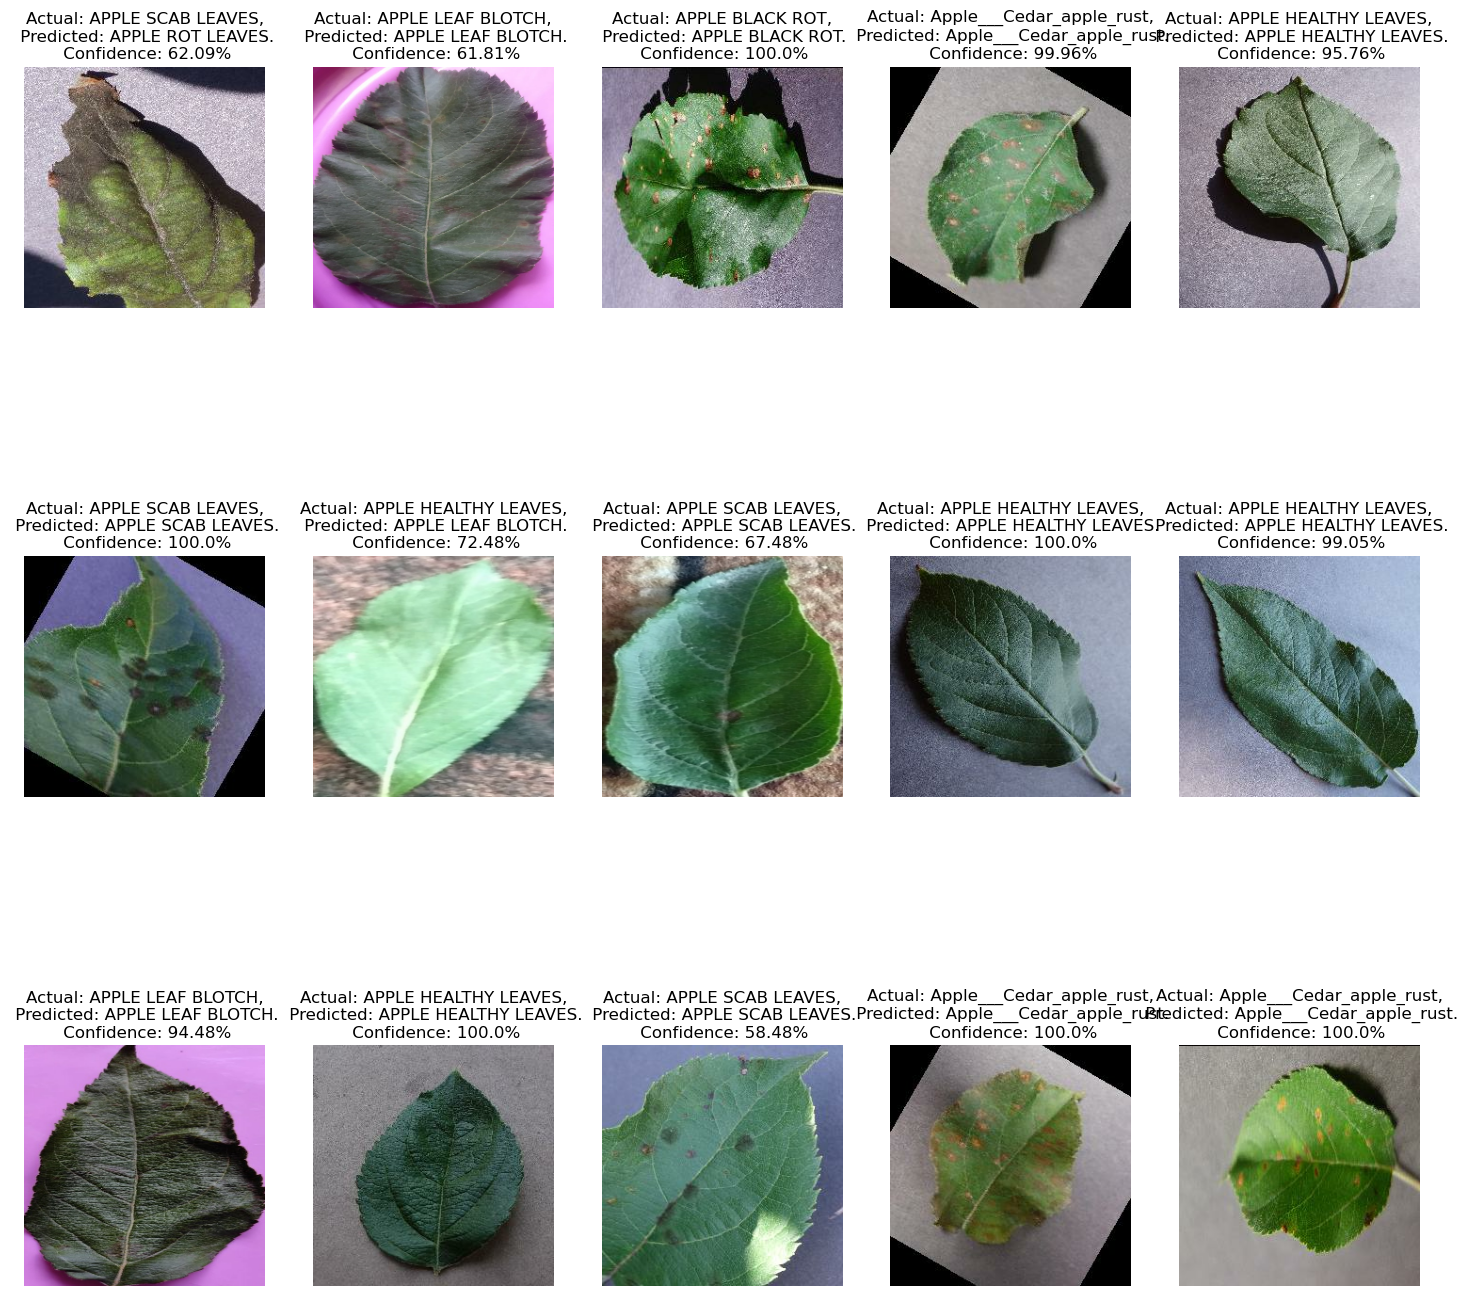

In [52]:
plt.figure(figsize=(18, 18))
for images, labels in test_ds.take(1):
    for i in range(15):
        ax = plt.subplot(3, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [53]:
import os
os.listdir("../applemodel")

['3', '4']

In [54]:
import os
model_version=max([int(i) for i in os.listdir("../applemodel") + [0]])+1
model.save(f"../applemodel/{model_version}")

INFO:tensorflow:Assets written to: ../applemodel/5\assets


INFO:tensorflow:Assets written to: ../applemodel/5\assets


In [55]:
model.save("../apple.h5")